# Illustrating the Depositional Model

Below notebook tests out two deposition models:
* Deposition and hiatuses modelled using fractional Gaussian noise 
* Deposition and hiatuses modelled using a uncoupled Continous Time Random Walk following a Pareto or tempered Pareto distribution

In [ ]:
# Set User Paths #
src_path = "../Blind_Review_Code_Repository_2025/src/"

In [2]:
# Imports
import os
os.chdir(src_path)

from pareto import *
import numpy as np
import spectrum
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
from itertools import product
from scipy.stats import linregress, pareto, gaussian_kde, skew, kurtosis
from scipy.ndimage import uniform_filter1d
import matplotlib.gridspec as gridspec
import math
import scipy

## Haar Fluctuation Analysis Functions
from haarFluctuationAnalysis import Haar_hebert, arns_haar_fluct
from analysisFunctions import linregress_wrapper, bin_data_max_log_bin

## Uncoupled Continous Time Random Walk

### Examples of the Pareto and tempered Pareto distributions

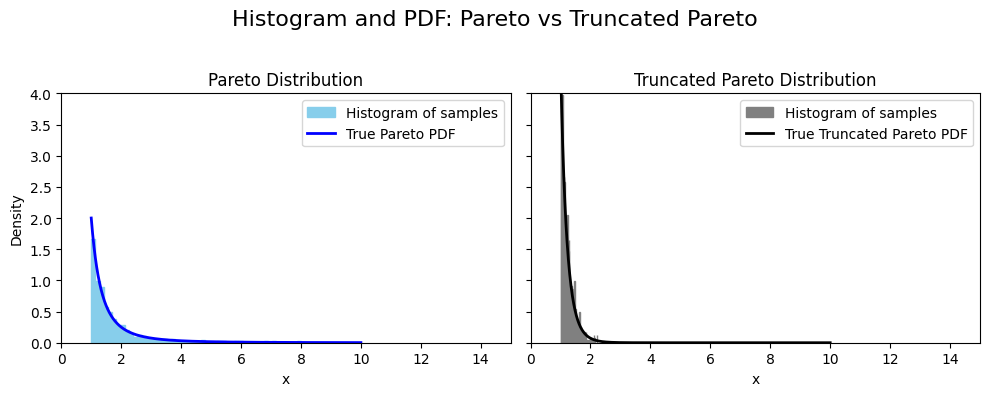

In [ ]:
# Plot of distributions
lam = 2
a = 1
theta = 0.4
n = 1000
x_vals = np.linspace(a, 10, n)

# --- Pareto ---
pareto_pdf = dpareto(x_vals, lam, a)
pareto_rvs = rpareto(n, lam, a)

# --- Tempered Pareto ---
tempered_pdf = dtappareto(x_vals, lam, theta, a)
tempered_rvs = rtappareto(n, lam, theta, a)

# --- Create subplots ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# --- Plot 1: Pareto ---
axes[0].hist(pareto_rvs, bins=50, density=True, color="skyblue", edgecolor="skyblue",
             range=(a, np.percentile(pareto_rvs, 99)), label="Histogram of samples")
axes[0].plot(x_vals, pareto_pdf, color="blue", linewidth=2, label="True Pareto PDF")
axes[0].set_title("Pareto Distribution")
axes[0].set_xlim(0, 15)
axes[0].set_ylim(0, 4)
axes[0].set_xlabel("x")
axes[0].set_ylabel("Density")
axes[0].legend()

# --- Plot 2: Truncated Pareto ---
axes[1].hist(tempered_rvs, bins=50, density=True, color="grey", edgecolor="grey",
             range=(a, np.percentile(tempered_rvs, 99)), label="Histogram of samples")
axes[1].plot(x_vals, tempered_pdf, color="black", linewidth=2, label="True Truncated Pareto PDF")
axes[1].set_title("Truncated Pareto Distribution")
axes[1].set_xlim(0, 15)
axes[1].set_ylim(0, 4)
axes[1].set_xlabel("x")
axes[1].legend()

# --- Final layout ---
plt.suptitle("Histogram and PDF: Pareto vs Truncated Pareto", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

save_path = "../Figures/Supplementary Figures/SFig5.png"
plt.savefig(save_path, format='png', dpi=600, bbox_inches='tight',transparent=False)


Pareto distribution under different cutoff values and random draws.

In [4]:
# Define parameter grid
pareto_cutoff = [100, 1000, 5000]
step_counts = [100, 250]

# Create all combinations of parameters
pareto_grid = pd.DataFrame(
    list(product(pareto_cutoff, step_counts)),
    columns=["cutoff", "step_count"]
)

# Collect statistics and full distributions
results = []
sampled_distributions = []  # <-- Store the actual sampled values here

for idx, row in pareto_grid.iterrows():
    cutoff = row["cutoff"]
    xmin = 1
    n_samples = row["step_count"]
    
    rvs = []
    while len(rvs) < n_samples:
        rv = rpareto(n=1, lam=0.4, a=xmin).astype(int)[0]
        if rv <= cutoff:
            rvs.append(rv)
    
    # Save distribution
    sampled_distributions.append({
        "cutoff": cutoff,
        "xmin": xmin,
        "step_count": n_samples,
        "samples": rvs  # List of sampled values
    })
    
    # Calculate moments
    mean_val = np.mean(rvs)
    var_val = np.var(rvs)
    skew_val = skew(rvs)
    kurt_val = kurtosis(rvs, fisher=False)  # Pearson definition

    results.append({
        "cutoff": cutoff,
        "xmin": xmin,
        "step_count": n_samples,
        "mean": mean_val,
        "variance": var_val,
        "skewness": skew_val,
        "kurtosis": kurt_val
    })

# Final result: summary DataFrame
results_df = pd.DataFrame(results)

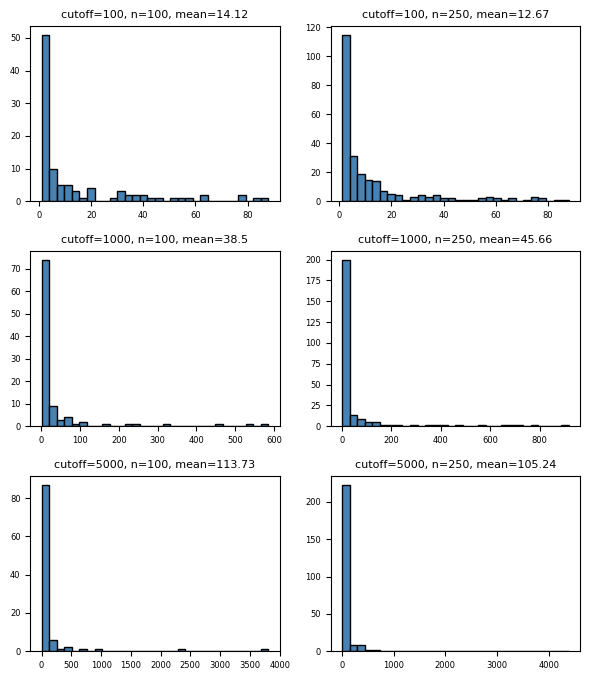

In [ ]:
# Plots of different Pareto Parameters

# Get unique values in consistent order
cutoff_vals = sorted(set(d["cutoff"] for d in sampled_distributions))
step_count_vals = sorted(set(d["step_count"] for d in sampled_distributions))
xmin_vals = sorted(set(d["xmin"] for d in sampled_distributions))

# Define grid size
n_rows = len(cutoff_vals)
n_cols = len(step_count_vals)

# Plot each xmin in a separate figure
for xmin in xmin_vals:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2.5*n_rows), sharex=False, sharey=False)
    #fig.suptitle(f"Distributions for xmin = {xmin}", fontsize=16)

    # Go through all subplot grid positions
    for i, cutoff in enumerate(cutoff_vals):
        for j, step_count in enumerate(step_count_vals):
            ax = axes[i, j] if n_rows > 1 else axes[j]

            # Find the corresponding distribution
            match = next((d for d in sampled_distributions if 
                          d["cutoff"] == cutoff and 
                          d["step_count"] == step_count and 
                          d["xmin"] == xmin), None)
            
            if match:
                ax.hist(match["samples"], bins=30, color='steelblue', edgecolor='k')
                ax.set_title(f'cutoff={cutoff}, n={step_count}, mean={np.round(np.mean(match["samples"]),2)}', fontsize=8)
            else:
                ax.set_visible(False)

            ax.tick_params(labelsize=6)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for suptitle

save_path = "../Figures/Supplementary Figures/SFig6.png"
plt.savefig(save_path, format='png', dpi=600, bbox_inches='tight',transparent=False)

### Simulated Stratigraphy using an Uncoupled Continous Time Random Walk

/var/folders/7g/bh9vvyp918n6wpybpv5cslxm0000gn/T/ipykernel_78708/1892572921.py:62: RuntimeWarning: invalid value encountered in divide
  v_obs = (elevation - s0) / (times - t0)
/var/folders/7g/bh9vvyp918n6wpybpv5cslxm0000gn/T/ipykernel_78708/1892572921.py:96: RuntimeWarning: divide by zero encountered in log10
  axs[0,0].scatter(np.log10(times), np.log10(elevation), s=1, c="black", label="Sediment Surface")
/var/folders/7g/bh9vvyp918n6wpybpv5cslxm0000gn/T/ipykernel_78708/1892572921.py:110: RuntimeWarning: divide by zero encountered in log10
  axs[0,1].scatter(np.log10(elevation), np.log10(v_obs), s=1, c="black", label="Observed Deposition Rate")
/var/folders/7g/bh9vvyp918n6wpybpv5cslxm0000gn/T/ipykernel_78708/1892572921.py:137: RuntimeWarning: divide by zero encountered in log10
  axs[1,1].plot(np.log10(x_freq), np.log10(y_power), color="grey", label="PSD Accumulation Rate", alpha=0.75, linewidth=0.5)


Max Time Steps: 47188


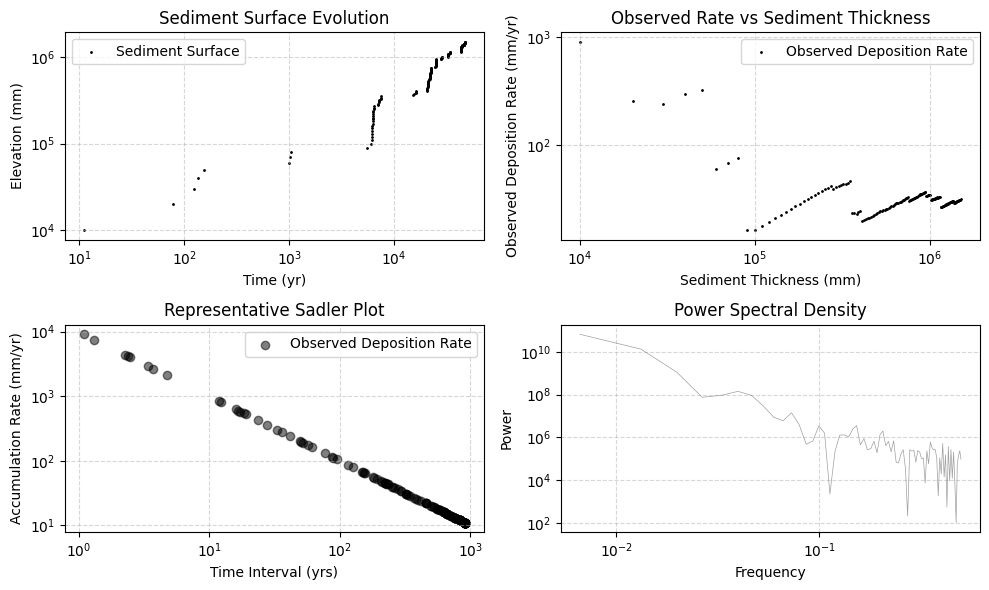

In [ ]:
# Run simulation and Plot

# Set intervals
times = [0]
elevation = [0]
obs_record =[]
t = 0
s = 0
step = 0
num_steps = 150

# Sim Parameters
gamma = 0.4
lam = 1/10000  # tempering parameter
xmin = 1         # minimum hiatus duration (year)
deposition_rate = 1000  # cm/yr
deposition_duration = 10  # 1000 years
deposition_thickness = deposition_rate * deposition_duration  # deposition = 10 cm
max_time = 1e6  # max total simulated time in kyr (stop condition)
cutoff = 10000

def get_hiatus(cutoff):
    while True:
        hiatus = scipy.stats.levy.rvs(loc=1, scale=0.25, size=1).astype(int)[0]
        if hiatus <= cutoff:
            return hiatus

while step < num_steps:
    # Setting the hiatuses
    while True:
        #hiatus = scipy.stats.levy.rvs(loc=1, scale=0.25, size=1).astype(int)[0]
        #hiatus = scipy.stats.pareto.rvs(b=0.4, scale=1, size=1).astype(int)[0]
        hiatus = rpareto(n=1, lam=0.4, a=1).astype(int)[0]
        if hiatus <= cutoff:
            break
    
    # The tempered pareto functions are not working... 
    #hiatus = rtappareto(n = 1, lam = 0.4, a = 1, theta = 1).astype(int)[0]

    t += hiatus
    obs_record.extend([False] * hiatus)  # Append hiatus
    t += deposition_duration
    obs_record.extend([True] * deposition_duration)  # Append deposition
    s += deposition_thickness
    times.append(t)
    elevation.append(s)
    step += 1

# Convert to arrays
elevation = np.array(elevation)
times = np.array(times)

# Fit line
#log_elev_plotA = np.log10(elevation[1:])
#log_times_plotA = np.log10(times[1:])
#slope_A, intercept_A = np.polyfit(log_elev_plotA, log_times_plotA, 1)
#y_fit_plotA = slope_A * log_elev_plotA + intercept_A

# Calculate observed deposition rate: elevation / time
t0 = times[0]
s0 = elevation[0]
v_obs = (elevation - s0) / (times - t0)
# Relative
#v_obs = [(elevation[i+1] - elevation[i]) / (times[i + 1] - times[i]) for i in range(len(times) - 1)]
v_obs[0] = 0.0

# Fit line
#mask = (elevation > 0) & (v_obs > 0)
#log_elev_plotB = np.log10(elevation[mask])
#log_vobs_plotB = np.log10(v_obs[mask])
#slope_B, intercept_B = np.polyfit(log_elev_plotB, log_vobs_plotB, 1)
#y_fit_plotB = slope_B * log_elev_plotB + intercept_B

# Accumulation Rate
accum_rate = np.diff(elevation) / np.diff(times)

# PSD Estimate
psd_sed_rate = spectrum.mtm.MultiTapering(times, NW=2, k=3)
# Normal
x_freq = psd_sed_rate.frequencies()
y_power = psd_sed_rate.psd

########
# Plot #
########
# --------- Log Tick Formatter Function ---------
def log_tick_formatter(val, pos):
    return f"$10^{{{int(val)}}}$"

# --------- Plotting ---------
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# --- Subplot 1: Sediment Elevation vs Time ---
#axs[0,0].plot(np.log10(times), np.log10(elevation), label="Sediment Surface", linewidth=2, alpha=0.5)
#axs[0].plot(log_elev_plotA, y_fit_plotA, color='black', label=f'Slope: {slope_A:.2f}')
axs[0,0].scatter(np.log10(times), np.log10(elevation), s=1, c="black", label="Sediment Surface")
axs[0,0].set_xlabel("Time (yr)")
axs[0,0].set_ylabel("Elevation (mm)")
axs[0,0].set_title("Sediment Surface Evolution")

axs[0,0].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0,0].yaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0,0].xaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))
axs[0,0].yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))
axs[0,0].grid(True, which="both", ls="--", alpha=0.5)
axs[0,0].legend()

# --- Subplot 2: v_obs vs Elevation ---
#axs[0,1].plot(np.log10(elevation), np.log10(v_obs), label="Observed Deposition Rate", linewidth=2, alpha=0.5)
axs[0,1].scatter(np.log10(elevation), np.log10(v_obs), s=1, c="black", label="Observed Deposition Rate")
#axs[1].plot(log_elev_plotB, y_fit_plotB, color='black', label=f'Slope: {slope:.2f}')
axs[0,1].set_xlabel("Sediment Thickness (mm)")
axs[0,1].set_ylabel("Observed Deposition Rate (mm/yr)")
axs[0,1].set_title("Observed Rate vs Sediment Thickness")

axs[0,1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0,1].yaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0,1].xaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))
axs[0,1].yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))
axs[0,1].grid(True, which="both", ls="--", alpha=0.5)
axs[0,1].legend()

# --- Subplot 3: Representative "Sadler Plot" ---
axs[1,0].scatter(np.log10(accum_rate), np.log10(np.diff(times)), label="Observed Deposition Rate", c = "black", alpha=0.5)
axs[1,0].set_xlabel("Time Interval (yrs)")
axs[1,0].set_ylabel("Accumulation Rate (mm/yr)")
axs[1,0].set_title("Representative Sadler Plot")

axs[1,0].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[1,0].yaxis.set_major_locator(ticker.MultipleLocator(1))
axs[1,0].xaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))
axs[1,0].yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))
axs[1,0].grid(True, which="both", ls="--", alpha=0.5)
axs[1,0].legend()

# --- Subplot 4: PSD Accumulation ---
axs[1,1].plot(np.log10(x_freq), np.log10(y_power), color="grey", label="PSD Accumulation Rate", alpha=0.75, linewidth=0.5)
axs[1,1].set_xlabel("Frequency")
axs[1,1].set_ylabel("Power")
axs[1,1].set_title("Power Spectral Density")

axs[1,1].xaxis.set_major_locator(ticker.MultipleLocator(1))
axs[1,1].yaxis.set_major_locator(ticker.MultipleLocator(2))
axs[1,1].xaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))
axs[1,1].yaxis.set_major_formatter(ticker.FuncFormatter(log_tick_formatter))
axs[1,1].grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()

print(f'Max Time Steps: {max(times)}')

save_path = "../Figures/Supplementary Figures/SFig7.png"
plt.savefig(save_path, format='png', dpi=600, bbox_inches='tight',transparent=False)